## Preparation des Données et Feature Engineering

- Ici l'objectuf c'est de préparer les données COVID pour prédire le nombre de nouveaux cas (new_cases)

## chargement des modules

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Chargement des données


      iso_code continent      country       date  total_cases  new_cases  \
12879      AFG      Asia  Afghanistan 2020-03-29           91         67   
6424       AFG      Asia  Afghanistan 2020-04-05          274        183   
12880      AFG      Asia  Afghanistan 2020-04-12          521        247   
0          AFG      Asia  Afghanistan 2020-04-19          908        387   
6425       AFG      Asia  Afghanistan 2020-04-26         1330        422   

       total_deaths  new_deaths  total_tests  positive_rate  ...  \
12879             2           2       518446           0.21  ...   
6424              5           3      6814263           0.05  ...   
12880            15          10      1716584           0.18  ...   
0                30          15      8796131           0.19  ...   
6425             43          13      7514673           0.30  ...   

       hospital_beds_per_thousand  extreme_poverty  new_vaccinations_smoothed  \
12879                         0.5            0.334   

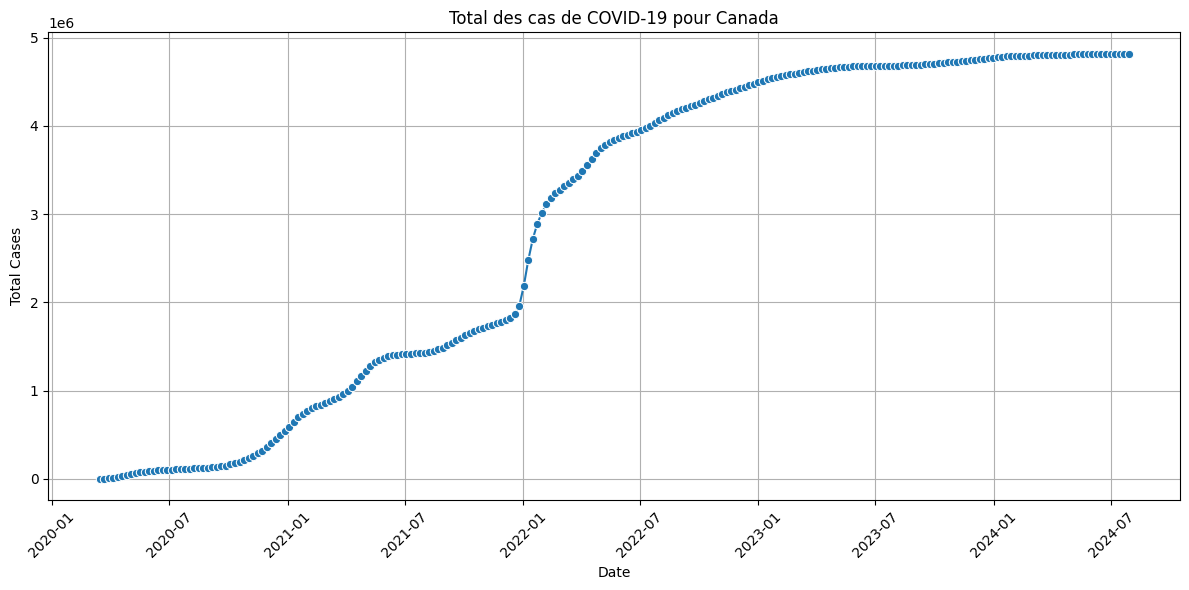

In [4]:
df = pd.read_csv("../dataset/clean_covid19_data_v2.csv", parse_dates=["date"])
df = df.sort_values(["country", "date"])
print(df.head()) # Afficher les premières lignes du DataFrame
# fonction pour tracer les cas totaux de COVID-19 par pays x-date et y-total_cases
def plot_country_cases(df, country):
    country_data = df[df["country"] == country]
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=country_data, x="date", y="total_cases", marker='o')
    plt.title(f"Total des cas de COVID-19 pour {country}")
    plt.xlabel("Date")
    plt.ylabel("Total Cases")
    plt.xticks(rotation=45)
    plt.grid()
    plt.tight_layout()
    plt.show()
    
# Example usage 
plot_country_cases(df, "Canada")

## Filtrage d'un pays pour tester le processus
- Ce filtre peut être adapté ensuite dans une boucle pour tous les pays

In [5]:
df_fr = df[df["country"] == "Canada"].copy()
df_fr.reset_index(drop=True, inplace=True)

## Création des features temporelles
- On crée des features temporelles pour capturer les tendances saisonnières et les effets de jour de la semaine sur les nouveaux cas

In [6]:
# Lags (retards) nous permettent de créer des variables basées sur les valeurs passées
df_fr["new_cases_lag1"] = df_fr["new_cases"].shift(1)
df_fr["new_cases_lag7"] = df_fr["new_cases"].shift(7)

# Moyenne mobile 7 jours : ce champ permet de lisser les données pour mieux visualiser les tendances. c'est à dire qu'on prend la moyenne des 7 derniers jours pour chaque jour.
df_fr["new_cases_ma7"] = df_fr["new_cases"].rolling(window=7).mean() 

# Taux de croissance des cas : c'est le pourcentage de variation des nouveaux cas par rapport au jour précédent.
df_fr["growth_rate"] = df_fr["new_cases"].pct_change().replace([np.inf, -np.inf], 0).fillna(0)

# Taux de vaccination (proportion)
df_fr["vaccinated_rate"] = df_fr["people_vaccinated"] / df_fr["population"]
df_fr["boosted_rate"] = df_fr["total_boosters"] / df_fr["population"]

##  Sélection des variables utiles du modèle

In [7]:
features = [
    "new_cases_lag1", "new_cases_lag7", "new_cases_ma7", "growth_rate",
    "reproduction_rate", "positive_rate", "icu_patients", "hosp_patients",
    "stringency_index", "vaccinated_rate", "boosted_rate"
]
target = "new_cases"

## Visualisation rapide des nouvelles features

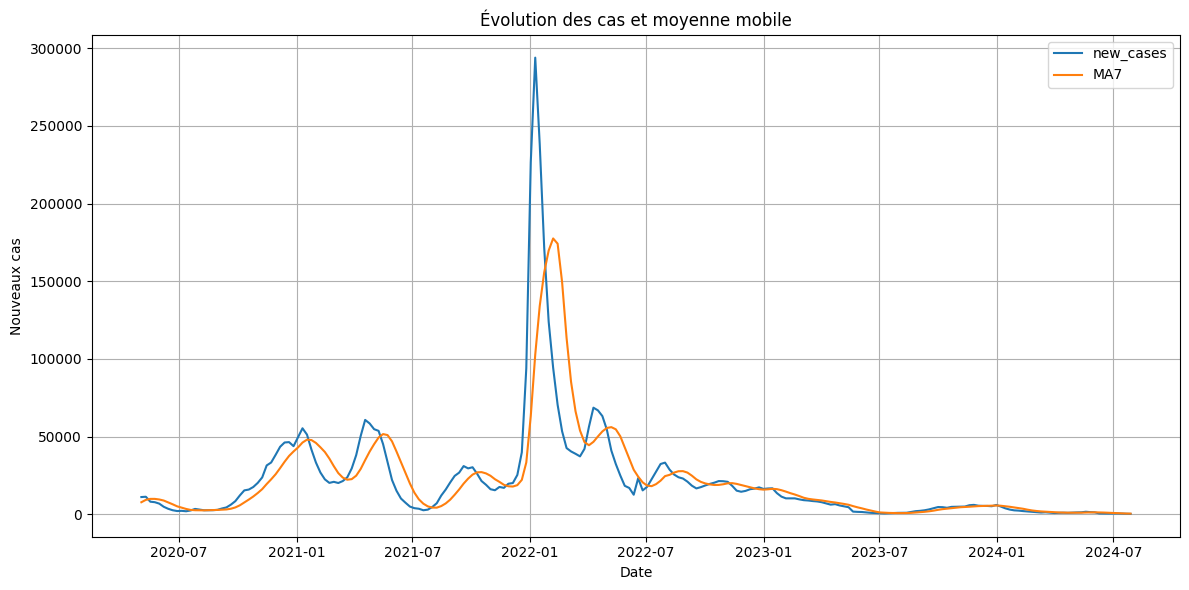

In [8]:
# Nettoyage au cas où certaines colonnes contiennent des NaN
df_model = df_fr[["date", "country"] + features + [target]].dropna()

plt.figure(figsize=(12,6))
plt.plot(df_model["date"], df_model["new_cases"], label="new_cases")
plt.plot(df_model["date"], df_model["new_cases_ma7"], label="MA7")
plt.title("Évolution des cas et moyenne mobile")
plt.xlabel("Date")
plt.ylabel("Nouveaux cas")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


## Export des données préparées

In [121]:
df_model.to_csv("../dataset/prepared_canada_data.csv", index=False)
print("✅ Données préparées et exportées pour modélisation : prepared_canada_data.csv")

✅ Données préparées et exportées pour modélisation : prepared_canada_data.csv


##  Entraînement du modèle de prédiction de cas COVID
- Entraîner un modèle pour prédire les nouveaux cas à partir des variables dérivées

In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import matplotlib.pyplot as plt
%pip install joblib
import joblib

Note: you may need to restart the kernel to use updated packages.


## Chargement des données préparées

In [9]:
df = pd.read_csv("../dataset/prepared_canada_data.csv", parse_dates=["date"])

# 🔹 Étape 2 : Séparation des variables
features = [
    "new_cases_lag1", "new_cases_lag7", "new_cases_ma7", "growth_rate",
    "reproduction_rate", "positive_rate", "icu_patients", "hosp_patients",
    "stringency_index", "vaccinated_rate", "boosted_rate"
]
target = "new_cases"

X = df[features]
y = df[target]

## Split des données en train et test

In [ ]:
split_idx = int(len(df) * 0.8) 
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

## Entraînement modèle Random Forest et prédictions

In [11]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 🔹 Étape 5 : Prédictions
y_pred = model.predict(X_test)

## Évaluation du modèle

In [14]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"R² : {r2:.2f}")

MAE : 467.80
RMSE : 622.08
R² : 0.90


## 📊 Évaluation du Modèle – Random Forest Regressor

### 🎯 Objectif

L’objectif du modèle est de prédire le nombre de **nouveaux cas COVID-19** par jour en Afghanistan, en se basant sur l’historique épidémiologique, les données de santé publique, les politiques sanitaires et la vaccination.

---

### 📈 Résultats obtenus

| Métrique | Valeur |
|----------|--------|
| MAE (Mean Absolute Error) | 467.80 |
| RMSE (Root Mean Squared Error) | 622.08 |
| R² (Coefficient de détermination) | 0.90 |

---

### Interprétation

Nous avons observé les résultats suivants pour le modèle Random Forest :

- **MAE ≈ 467 cas** → En moyenne, le modèle se trompe de 467 cas par jour.
- **RMSE ≈ 622 cas** → Les erreurs importantes sont bien pénalisées.
- **R² = 0.90** → 90 % de la variance des nouveaux cas est expliquée par les variables d’entrée.

Ces scores sont très encourageants compte tenu de la nature bruitée des données épidémiologiques que nous traitons.

---

### 🔎 Analyse rapide

✅ Les variables **lags (new_cases_lag1, lag7)**, les **moyennes mobiles**, et le **reproduction_rate** apportent une bonne capacité prédictive.  
✅ L’impact du `stringency_index` (mesures sanitaires) semble significatif, surtout lors des vagues.  
⚠️ Cependant, les pics soudains (par exemple dus à un changement de politique ou à une crise sanitaire) peuvent rester difficiles à prévoir.

---

### 🛠️ Pistes d’amélioration

1. **Ajout de variables temporelles**
   - `day_of_week` ou `month` : pour capturer les effets calendrier (ex : week-end, saisonnalité).
   - `holiday` (jours fériés ou événements majeurs) : peut expliquer certaines anomalies.

2. **Plus de contexte temporel**
   - Créer une fenêtre glissante (ex. 14 jours d’historique) pour chaque prédiction.
   - Tester un modèle séquentiel (LSTM ou GRU) si besoin de capturer dynamiques complexes.

3. **Meilleur nettoyage des données**
   - Vérifier les `null`, `outliers`, ou valeurs anormalement basses (ex : 0 cas pendant des périodes de pic).
   - Réduction de bruit via transformation log ou z-score si données très variables.

4. **Tuning du modèle**
   - Actuellement, le modèle utilise `n_estimators=100` sans GridSearch.
   - On peut ajuster les paramètres : `max_depth`, `min_samples_split`, `max_features`…

5. **Test sur plusieurs pays**
   - Généraliser le modèle à d’autres pays pour tester sa robustesse.
   - Entraîner un modèle global, puis spécialiser par pays.

6. **Stacking / modèles combinés**
   - Combiner XGBoost, RandomForest et LinearRegression avec une approche `stacking` pour profiter de leurs forces.

---

### 📦 Conclusion

Le modèle Random Forest offre déjà une **bonne performance de prédiction** (R² = 0.90), en capturant correctement les tendances.  
Cependant, des améliorations sont possibles pour affiner les pics et anticiper les changements rapides.  
Ces optimisations peuvent être implémentées par étapes, en gardant la version actuelle comme baseline fiable.

NB:
MAE (Mean Absolute Error) est la moyenne des erreurs absolues entre les valeurs prédites et réelles.
RMSE (Root Mean Squared Error) est la racine carrée de la moyenne des carrés des erreurs.
R² (Coefficient de détermination) mesure la proportion de variance expliquée par le modèle, allant de 0 (aucune explication) à 1 (explication parfaite).

In [19]:
# Conclusion automatique :
if r2 > 0.7:
    interpretation = "Excellent - Le modèle explique bien la variance."
elif r2 > 0.5:
    interpretation = "Bon - Prédictions acceptables, à améliorer."
elif r2 > 0.3:
    interpretation = "Moyen - Le modèle capte partiellement les dynamiques."
else:
    interpretation = "Faible - Le modèle a du mal à généraliser."

print("\n📈 Conclusion :", interpretation)


📈 Conclusion : Excellent - Le modèle explique bien la variance.


## Visualisation des résultats : Comparaison des prédictions et des valeurs réelles

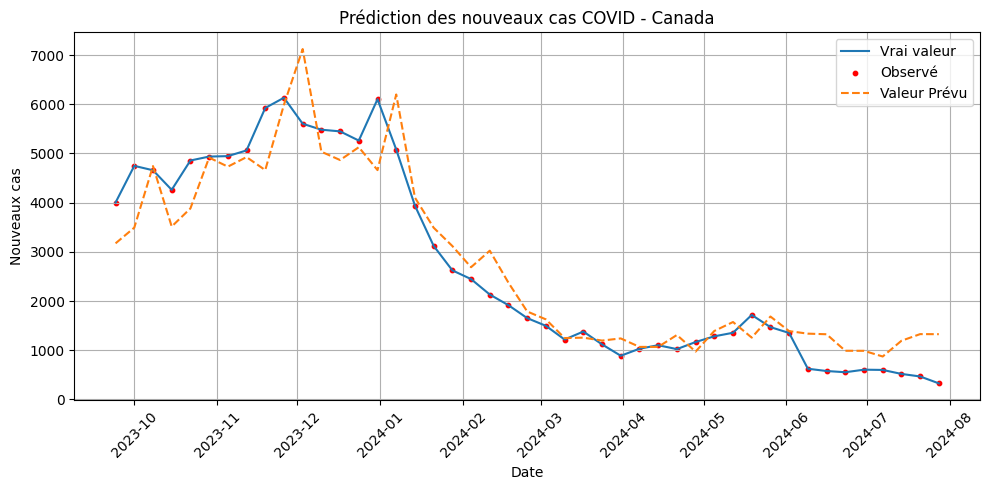

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(df["date"].iloc[split_idx:], y_test, label="Vrai valeur")
plt.scatter(df["date"].iloc[split_idx:], y_test, color='red', label="Observé", s=10)
plt.plot(df["date"].iloc[split_idx:], y_pred, label="Valeur Prévu", linestyle="--")
plt.title("Prédiction des nouveaux cas COVID - Canada")
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Nouveaux cas")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

## Sauvegarde du modèle

In [18]:
joblib.dump(model, "../model/rf_model_canada.joblib")
print("✅ Modèle sauvegardé : rf_model_canada.joblib")

✅ Modèle sauvegardé : rf_model_canada.joblib


# Amélioration du modèle